<a href="https://colab.research.google.com/github/Satya-1729/Python_machine_learning/blob/main/human_action_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python
!pip install pafy
!pip install youtube-dl
!pip install tensorflow
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.4 MB/s eta 0:00:00


In [ ]:
!pip install moviepy
!pip show moviepy
!pip install --upgrade moviepy
import sys
print(sys.executable)

from moviepy import *
from moviepy import VideoFileClip





Name: moviepy
Version: 1.0.3
Summary: Video editing with Python
Home-page: https://zulko.github.io/moviepy/
Author: Zulko 2017
Author-email: 
License: MIT License
Location: /usr/local/lib/python3.11/dist-packages
Requires: decorator, imageio, imageio-ffmpeg, numpy, proglog, requests, tqdm
Required-by: 
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: moviepy
    Found existing installation: moviepy 1.0.3
    Uninstalling moviepy-1.0.3:
      Successfully uninstalled moviepy-1.0.3


/usr/bin/python3


In [ ]:

%matplotlib inline
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# discarding the output of this cell
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

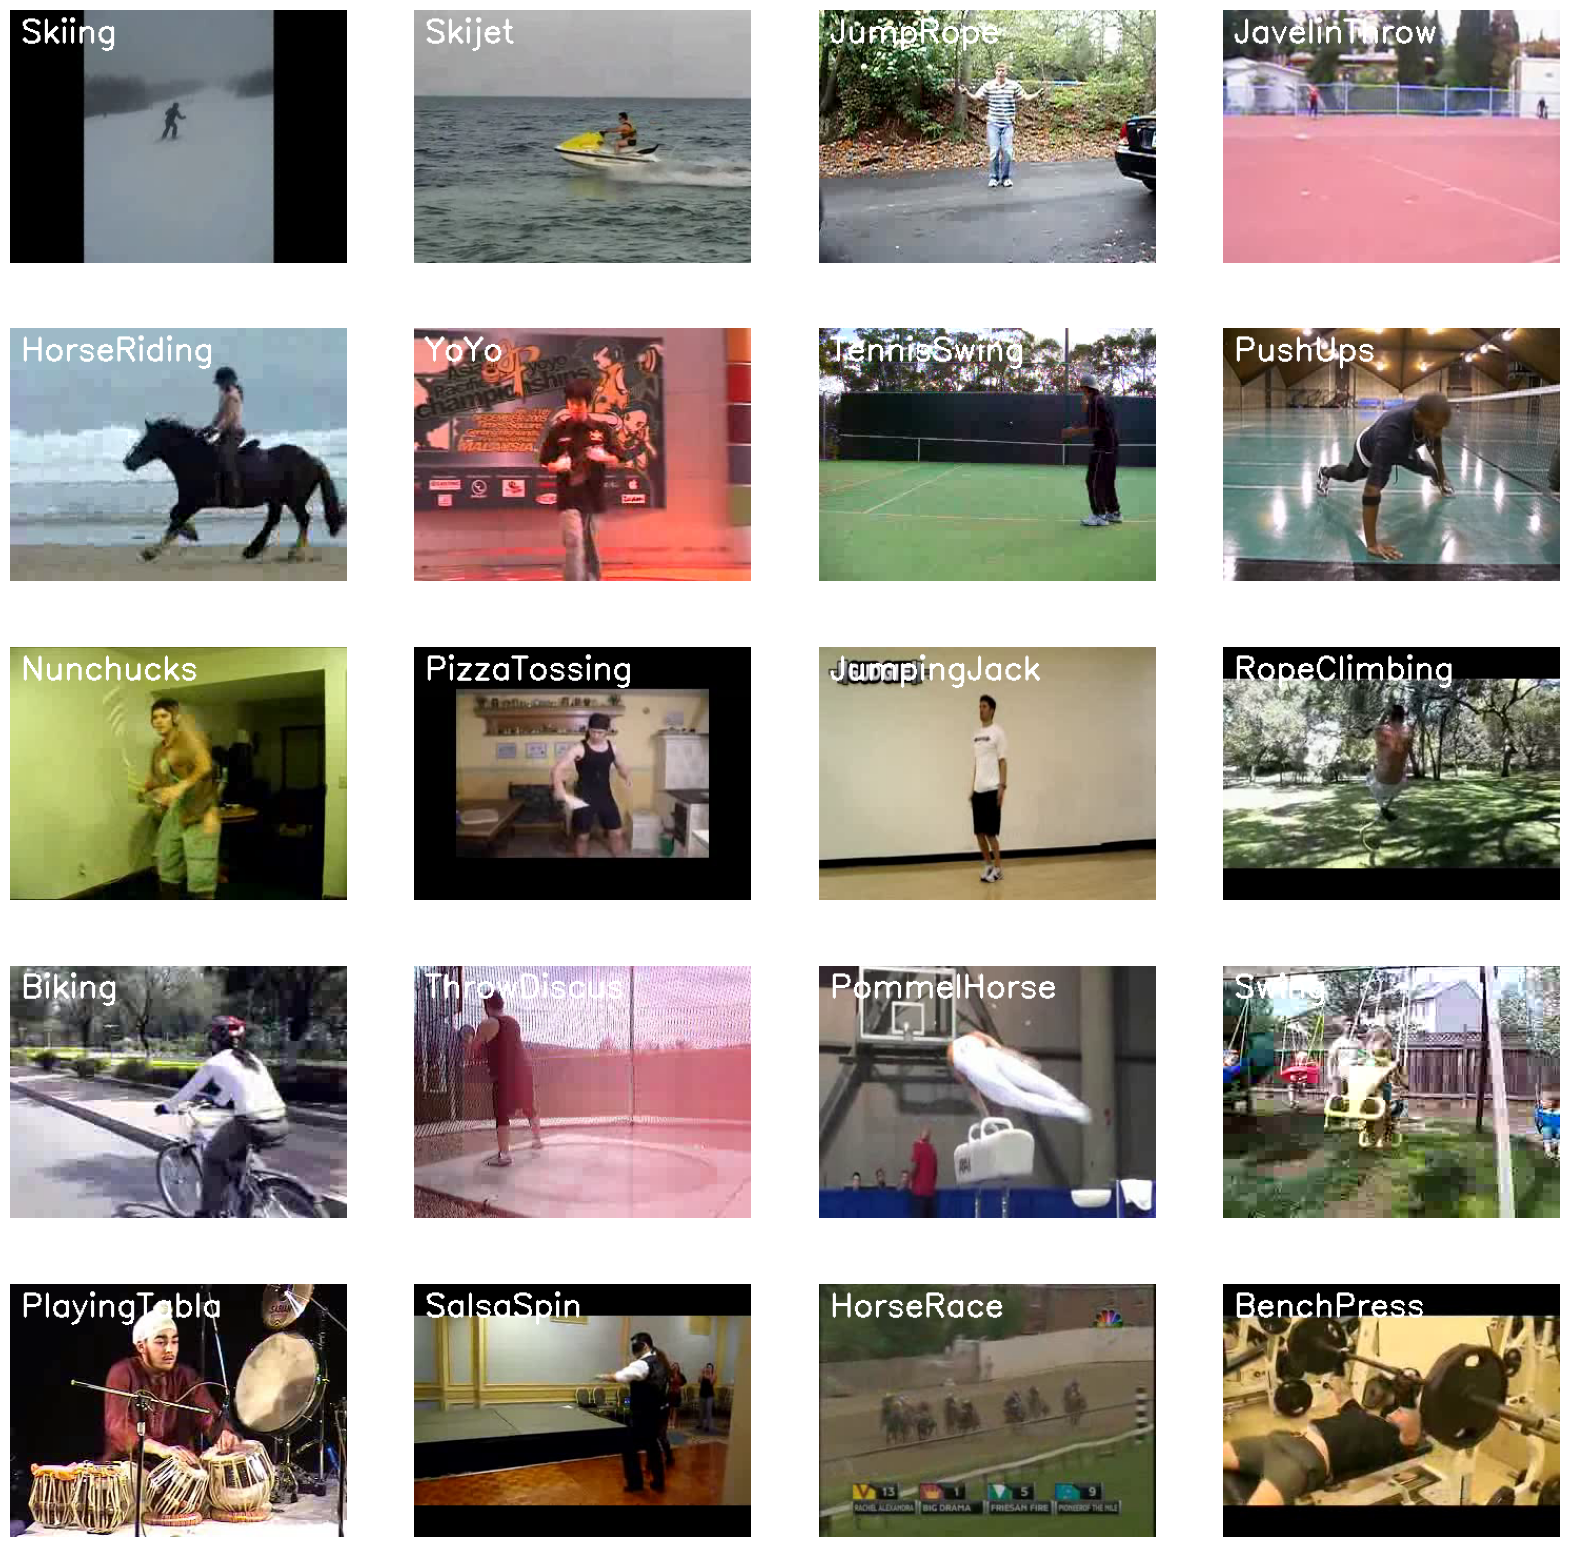

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('/content/UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'/content/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'/content/UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/UCF50"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

def frames_extraction(video_path):

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Split the Data into Train (75%) and Test Set (25%)
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size=0.25,
    shuffle=True,
    random_state=seed_constant
)


In [ ]:
def create_convlstm_model():


    # We will use a Sequential model for model construction
    model = Sequential()


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model


In [ ]:
# Construct the required ConvLSTM model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")




In [ ]:
# Plot the structure of the constructed model.
plot_model(
    convlstm_model,
    to_file='convlstm_model_structure_plot.png',
    show_shapes=True,
    show_layer_names=True
)

# Create an instance of EarlyStopping callback.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Compile the model and specify loss function, optimizer, and metrics.
convlstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=["accuracy"]
)

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime object.
# Convert the DateTime object to a string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for the model to make it easy for us while navigating through multiple saved models.
model_file_name = (
    f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
)

# Save your model.
convlstm_model.save(model_file_name)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.2087 - loss: 1.4040 - val_accuracy: 0.2466 - val_loss: 1.3664
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.2810 - loss: 1.3842 - val_accuracy: 0.2740 - val_loss: 1.3923
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3691 - loss: 1.3715 - val_accuracy: 0.5068 - val_loss: 1.2122
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5102 - loss: 1.1854 - val_accuracy: 0.4521 - val_loss: 1.4506
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5067 - loss: 1.1162 - val_accuracy: 0.6575 - val_loss: 0.9108
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6363 - loss: 0.8850 - val_accuracy: 0.6301 - val_loss: 0.8625
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6957 - loss: 0.7717 - val_accuracy: 0.6849 - val_loss: 0.7739
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.7368 - loss: 0.6834 - val_accuracy: 0.6986 - v

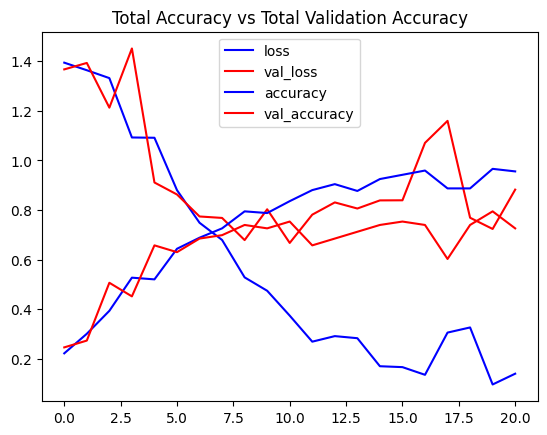

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!
Epoch 1/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.2265 - loss: 1.4115 - val_accuracy: 0.3973 - val_loss: 1.3622
Epoch 2/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 74s 558ms/step - accuracy: 0.3050 - loss: 1.3501 - val_accuracy: 0.4932 - val_loss: 1.1566
Epoch 3/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - accuracy: 0.4582 - loss: 1.1379 - val_accuracy: 0.5753 - val_loss: 1.0824
Epoch 4/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 81s 571ms/step - accuracy: 0.5160 - loss: 1.1264 - val_accuracy: 0.6986 - val_loss: 0.8952
Epoch 5/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 83s 593ms/step - accuracy: 0.5785 - loss: 0.9358 - val_accuracy: 0.7260 - val_loss: 0.7906
Epoch 6/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.7301 - loss: 0.8041 - val_accuracy: 0.6712 - val_loss: 0.7503
Epoch 7/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 80s 555ms/step - accuracy: 0.7180 - loss: 0.6929 - val_accuracy: 0.7671 - val_loss: 0.6018
Epoch 8/70
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 561ms/step - accuracy: 0.82

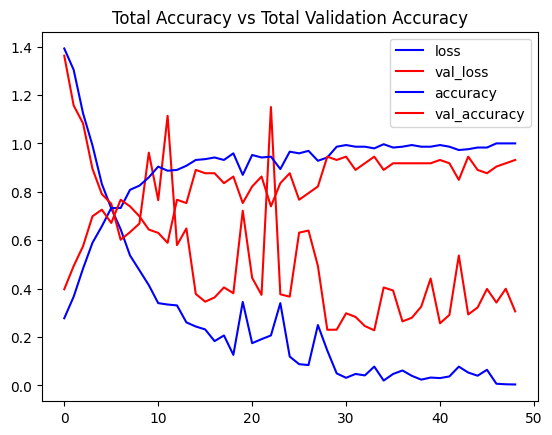

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


In [ ]:
from tensorflow.keras.models import load_model
from moviepy import VideoFileClip
# Define Constants
IMAGE_HEIGHT = 64  # Resize frame height
IMAGE_WIDTH = 64   # Resize frame width
SEQUENCE_LENGTH = 20  # Sequence length for frames
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

# CLASSES_LIST = ['Class1', 'Class2', 'Class3']  # List of classes

# Load the pre-trained model
LRCN_model = load_model('/content/LRCN_model___Date_Time_2025_04_01__04_36_30___Loss_0.3030868172645569___Accuracy_0.9098360538482666.h5')

video_title = os.path.splitext(os.path.basename(input_video_file_path))[0]

# Path to your saved video (replace this with the actual path)
input_video_file_path = '/content/drive/MyDrive/test/Test Video.mp4'

# Make the Output directory if it does not exist
test_videos_directory = '/content/drive/MyDrive/test'
os.makedirs(test_videos_directory, exist_ok=True)

# Construct the output video path
output_video_file_path = f'{test_videos_directory}/output_video.mp4'

def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path,
                                   cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS),
                                   (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
        # Read the frame.
        ok, frame = video_reader.read()

        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Append the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue is equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]

            # Get the index of the class with the highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame into the disk using the VideoWriter Object.
        video_writer.write(frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()




FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/LRCN_model___Date_Time_2025_04_01__04_36_30___Loss_0.3030868172645569___Accuracy_0.9098360538482666.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# Construct the output video path.
output_video_file_path = f'/content/drive/MyDrive/test/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.avi'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)




def show_video(file_path, width=640):
    """
    Displays a video in a Jupyter notebook.
    """
    video = VideoFileClip(file_path, audio=False, target_resolution=(width, None))
    video_data = video.write_videofile("/tmp/temp_video.mp4", codec="libx264", audio_codec="aac")
    video.close()

    with open("/tmp/temp_video.mp4", "rb") as f:
        video_bytes = f.read()

    encoded_video = b64encode(video_bytes).decode()
    display(HTML(data=f'<video width="{width}" controls><source src="data:video/mp4;base64,{encoded_video}" type="video/mp4"></video>'))

# Replace the line causing the error with the following:
show_video(output_video_file_path, width=300)